# One-class Support Vector Machine: OC-SVM

In this notebook we explore the using of OC-SVM for anomaly detection. For this purpose, we will use the following procedure:

1. We use the public test set for the training process. We randomly select 80% of the non-contaminated data for training, and the remaining 20% + contaminated data is used for validation.
2. The performance of the model was measured over the private test set.

We perform cross-validation to select the hyperparameter $\nu$, which intuitively means the amount of contaminated data in the dataset.


In [2]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import f1_score
from sklearn.svm import OneClassSVM

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [26]:
public_test = pd.read_pickle('test_data.pkl')
public_test = public_test.replace([np.inf, -np.inf], np.nan)

scaler = MinMaxScaler()
x_data = public_test.drop(['hierClass', 'classALeRCE', 'challenge_oid', 'outClass', 'outType'], axis=1)
x_data = scaler.fit(x_data).transform(x_data)
x_data[np.isnan(x_data)] = 0

y_data = public_test.outClass

In [3]:
def split_data(x, y):
    x_non_contaminated = x_data[y_data=='Inlier']
    y_non_contaminated = y_data[y_data=='Inlier'].values
    selected_ixs = np.random.choice(x_non_contaminated.shape[0], 
                                int(x_non_contaminated.shape[0]*0.2), replace=False)
    
    x_selected_test = x_non_contaminated[[selected_ixs]]
    y_selected_test = y_non_contaminated[[selected_ixs]]
    
    x_non_contaminated = np.delete(x_non_contaminated, selected_ixs, axis=0)    
    
    x_contaminated = x_data[y_data=='Outlier']
    y_contaminated = y_data[y_data=='Outlier'].values
    x_contaminated = np.concatenate((x_contaminated, x_selected_test), axis=0)
    y_contaminated = np.concatenate((y_contaminated, y_selected_test), axis=0)
    y_contaminated[y_contaminated=='Inlier']=1
    y_contaminated[y_contaminated=='Outlier']=-1
    
    return x_non_contaminated, x_contaminated, y_contaminated.astype('int')

In [4]:
nus = [0.001, 0.005, 0.01, 0.015]

mean_f1 = []
std_f1 = []
for nu in nus:
    f1s = []
    for rep in range(5):
        x_train, x_test, y_test = split_data(x_data, y_data)
        clf = OneClassSVM(kernel='rbf', nu=nu).fit(x_train)
        y_pred =  clf.predict(x_test)
        f1 = f1_score(y_test, y_pred, average='binary')
        f1s.append(f1)
        print('The f1-score for OC-SVM using nu={} is {}'.format(nu, f1*100))
    mean_f1.append(np.mean(f1s))
    std_f1.append(np.std(f1s))

The f1-score for OC-SVM using nu=0.001 is 90.7481508427307
The f1-score for OC-SVM using nu=0.001 is 90.80111501636165
The f1-score for OC-SVM using nu=0.001 is 90.80884580430173
The f1-score for OC-SVM using nu=0.001 is 90.74152670830048
The f1-score for OC-SVM using nu=0.001 is 90.78787878787878
The f1-score for OC-SVM using nu=0.005 is 90.61987736020885
The f1-score for OC-SVM using nu=0.005 is 90.6663430027916
The f1-score for OC-SVM using nu=0.005 is 90.59330782777677
The f1-score for OC-SVM using nu=0.005 is 90.6873748710793
The f1-score for OC-SVM using nu=0.005 is 90.52682748982195
The f1-score for OC-SVM using nu=0.01 is 90.46344726918866
The f1-score for OC-SVM using nu=0.01 is 90.49124513618676
The f1-score for OC-SVM using nu=0.01 is 90.35007610350075
The f1-score for OC-SVM using nu=0.01 is 90.47010886091346
The f1-score for OC-SVM using nu=0.01 is 90.34890093162029
The f1-score for OC-SVM using nu=0.015 is 90.21593265828962
The f1-score for OC-SVM using nu=0.015 is 90.135

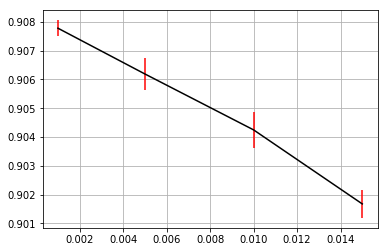

In [5]:
plt.errorbar(nus, mean_f1, yerr=std_f1, color='k', ecolor='r')
plt.grid()
plt.show()

## Using nu=0.001:

In [3]:
train = pd.read_pickle('train_data.pkl')
train = train[(train['n_det_1']>=10) & (train['n_det_2']>=10)]

importances = np.load('importances.npy').item()
x_train = train[importances['hierarchical_importance']]

scaler = QuantileTransformer(n_quantiles=5)
x_train = scaler.fit(x_train).transform(x_train)
x_train[np.isnan(x_train)] = 0


clf = OneClassSVM(kernel='rbf', nu=0.001).fit(x_train)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [4]:
test = pd.read_pickle('test_data.pkl')
test = test[(test['n_det_1']>=10) & (test['n_det_2']>=10)]

x_test = test[importances['hierarchical_importance']]

x_test = scaler.transform(x_test)
x_test[np.isnan(x_test)] = 0


In [5]:
x_in = x_test[test.outClass=='Inlier']
x_out = x_test[test.outClass=='Outlier']

x_ELL = x_test[test.classALeRCE == 'ELL']
x_TDE = x_test[test.classALeRCE == 'TDE']
x_SNIIb = x_test[test.classALeRCE == 'SNIIb']
x_WR = x_test[test.classALeRCE == 'WRayot']

In [6]:
scores_in =  clf.score_samples(x_in)
scores_out =  clf.score_samples(x_out)

scores_ELL = clf.score_samples(x_ELL)
scores_TDE = clf.score_samples(x_TDE)
scores_SNIIb = clf.score_samples(x_SNIIb)
scores_WR = clf.score_samples(x_WR)

(array([0.47529883, 0.47529883, 0.        , 0.47529883, 0.        ,
        0.        , 0.        , 0.        , 0.95059766, 0.47529883,
        0.95059766, 0.47529883, 0.95059766, 0.47529883, 0.47529883,
        0.47529883, 1.42589649, 0.47529883, 1.42589649, 0.95059766]),
 array([34.077703  , 34.16917864, 34.26065427, 34.3521299 , 34.44360553,
        34.53508116, 34.6265568 , 34.71803243, 34.80950806, 34.90098369,
        34.99245932, 35.08393496, 35.17541059, 35.26688622, 35.35836185,
        35.44983748, 35.54131312, 35.63278875, 35.72426438, 35.81574001,
        35.90721564]),
 <a list of 20 Patch objects>)

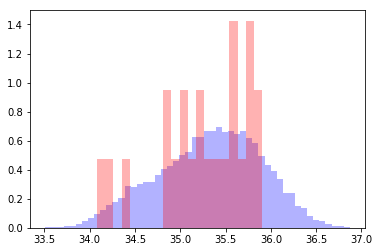

In [8]:
plt.hist(scores_in, bins=50, color='b', alpha=0.3, density=True, label='Inlier')
plt.hist(scores_out, bins=20, color='r', alpha=0.3, density=True, label='Outlier')

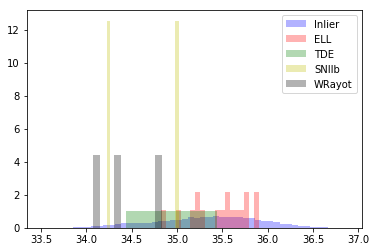

In [11]:
plt.hist(scores_in, bins=50, color='b', alpha=0.3, density=True, label='Inlier')
plt.hist(scores_ELL, bins=20, color='r', alpha=0.3, density=True, label='ELL')
plt.hist(scores_TDE, bins=1, color='g', alpha=0.3, density=True, label='TDE')
plt.hist(scores_SNIIb, bins=20, color='y', alpha=0.3, density=True, label='SNIIb')
plt.hist(scores_WR, bins=10, color='k', alpha=0.3, density=True, label='WRayot')
plt.legend()